<a href="https://colab.research.google.com/github/chandan2294/Artificial-Neural-Network/blob/master/Training_Deep_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Index:**



1.   Vanishing/Exploding Gradients Problem
2.   Glorot and He Initialization
3. Nonsaturating Activation Functions
  *   Leaky ReLU
  *   ELU Activation Function
  *   SELU
  *   Batch Normalization
4. Gradient Clipping
5. Reusing Pretrained Layers
  *   Reusing a Keras model
6. Faster Optimizers
  *   Momentum Optimization
  *   Nesterov Accelerated Gradient
  *   AdaGrad
  *   RMSProp
  *   Adam Optimization
  *   Adamax Optimization
  *   Nadam Optimization
7. Learning Rate Scheduling
  *   Power Scheduling
  *   Exponential Scheduling
  * Piecewise Constant Scheduling
  * Performance Scheduling
  * 1Cycle Scheduling
8. Avoid Overfitting Through Regularization
  * L1 and L2 Regularization
  * Dropout
  * Alpha Dropout
  * MC Dropout
  * Max Norm
  

















In [ ]:
#Setup

import sys
assert sys.version_info >= (3, 5)

#Scikit-Learn >= 0.20 is require
import sklearn
assert sklearn.__version__ >= "0.20"

try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "0.20"

%load_ext tensorboard

#Common imports
import numpy as np
import os

#To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

# **Vanishing/Exploding Gradients Problem**

The backpropagation algorithm works by going from
the output layer to the input layer, propagating the error gradient along the way. Once
the algorithm has computed the gradient of the cost function with regard to each
parameter in the network, it uses these gradients to update each parameter with a
Gradient Descent step.

Unfortunately, gradients often get smaller and smaller as the algorithm progresses
down to the lower layers. As a result, the Gradient Descent update leaves the lower
layers’ connection weights virtually unchanged, and training never converges to a
good solution. We call this the vanishing gradients problem. In some cases, the oppo
site
can happen: the gradients can grow bigger and bigger until layers get insanely
large weight updates and the algorithm diverges. This is the exploding gradients prob
lem,
which surfaces in recurrent neural networks. More generally,
deep neural networks suffer from unstable gradients; different layers may learn at
widely different speeds.



In [ ]:
def logit(z):
  return 1/(1 + np.exp(-z))

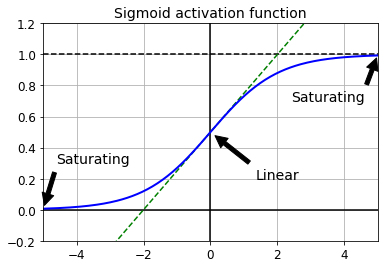

In [ ]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth = 2)
props = dict(facecolor = 'black', shrink = 0.1)
plt.annotate('Saturating', xytext = (3.5, 0.7), xy = (5, 1), arrowprops = props, fontsize = 14, ha = 'center')
plt.annotate('Saturating', xytext = (-3.5, 0.3), xy = (-5, 0), arrowprops = props, fontsize = 14, ha = 'center')
plt.annotate('Linear', xytext = (2, 0.2), xy = (0, 0.5), arrowprops = props, fontsize = 14, ha = "center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize = 14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

Looking at the logistic activation function, you can see that when
inputs become large (negative or positive), the function saturates at 0 or 1, with a
derivative extremely close to 0. Thus, when backpropagation kicks in it has virtually
no gradient to propagate back through the network; and what little gradient exists
keeps getting diluted as backpropagation progresses down through the top layers, so
there is really nothing left for the lower layers.

# Glorot and He initialization

In their paper, Glorot and Bengio propose a way to significantly alleviate the unstable
gradients problem. They point out that we need the signal to flow properly in both
directions: in the forward direction when making predictions, and in the reverse
direction when backpropagating gradients. We don’t want the signal to die out, nor
do we want it to explode and saturate. For the signal to flow properly, the authors
argue that we need the variance of the outputs of each layer to be equal to the variance
of its inputs, and we need the gradients to have equal variance before and after
flowing through a layer in the reverse direction. 

They proposed that connection weights of each layer must be initialized randomly and this initializing strategy is called *Xavier initialization* or *Glorot Initialization*. With the help of this initialization you can speed up trianing considerably.

*The initialization strategy for the ReLU activation function (and its variants) is sometimes called He initialization*

In [ ]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [ ]:
#Default = "Glorot initialization with a uniform distribution"

keras.layers.Dense(10, activation = 'relu', kernel_initializer='he_normal')

In [ ]:
#Initializing He Initialization with a uniform distribution
init = keras.initializers.VarianceScaling(scale = 2, mode = 'fan_avg',
                                          distribution = 'uniform')
keras.layers.Dense(10, activation='relu', kernel_initializer=init)

# Nonsaturating Activation Functions

The ReLU activation function suffers from a problem
known as the dying ReLUs: during training, some neurons effectively “die,” meaning
they stop outputting anything other than 0. In some cases, you may find that half of
your network’s neurons are dead, especially if you used a large learning rate. A neuron
dies when its weights get tweaked in such a way that the weighted sum of its
inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the
gradient of the ReLU function is zero when its input is negative. To solve this problem, you may want to use a variant of the ReLU function, such as the *leaky ReLU*

**Leaky ReLU:**

In [ ]:
def leaky_relu(z, alpha = 0.01):
  """
  Leaky ReLU(z) = max(alpha*z, z).
  alpha = how much the function "leaks": it is the slope of the function for 
  z < 0 and it is typically set to 0.01. This small slope ensures that leaky ReLUs
  never die.
  """
  return np.maximum(alpha*z, z)

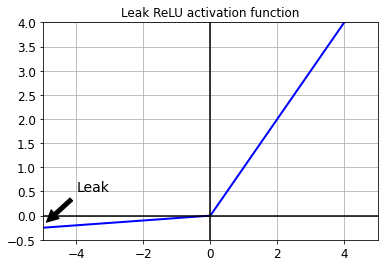

In [ ]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth = 2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor = 'black', shrink = 0.1)
plt.annotate("Leak", xytext = (-3.5, 0.5), xy = (-5, -0.2), arrowprops = props, fontsize = 14, ha = 'center')
plt.title('Leak ReLU activation function')
plt.axis([-5, 5, -0.5, 4])
plt.show()

In [ ]:
#List of activation function

[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [ ]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:


In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train_full = X_train_full/255.0
X_test = X_test/255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
print("Size of training set: ", X_train.shape)
print("Size of label training set: ", y_train.shape)
print("Size of validation set: ", X_valid.shape)
print("Size of label  validation set: ", y_valid.shape)
print("Size of testing set: ", X_test.shape)
print("Size of label testing set: ", y_test.shape)

Size of training set:  (55000, 28, 28)
Size of label training set:  (55000,)
Size of validation set:  (5000, 28, 28)
Size of label  validation set:  (5000,)
Size of testing set:  (10000, 28, 28)
Size of label testing set:  (10000,)


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
                                keras.layers.Flatten(input_shape = [28, 28]),
                                keras.layers.Dense(300, kernel_initializer='he_normal'),
                                keras.layers.LeakyReLU(),
                                keras.layers.Dense(100, kernel_initializer='he_normal'),
                                keras.layers.LeakyReLU(),
                                keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = keras.optimizers.SGD(lr=1e-3),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs = 10, 
                    validation_data = (X_valid, y_valid))

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy'][-1], history.history['val_accuracy'][-1]

(0.8320727348327637, 0.8393999934196472)

Now, let's try PReLU:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = keras.models.Sequential([
              keras.layers.Flatten(input_shape = [28, 28]),
              keras.layers.Dense(300, kernel_initializer='he_normal'),
              keras.layers.PReLU(),
              keras.layers.Dense(100, kernel_initializer='he_normal'),
              keras.layers.PReLU(),
              keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(learning_rate=1e-3),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs = 10, 
                    validation_data = (X_valid, y_valid))

In [ ]:
history.history['accuracy'][-1], history.history['val_accuracy'][-1]

(0.8315818309783936, 0.8398000001907349)

**ELU activation function:**

The ELU activation function looks a lot like the ReLU function, with a few major
differences:
* It takes on negative values when z < 0, which allows the unit to have an average
output closer to 0 and helps alleviate the vanishing gradients problem. The
hyperparameter $\alpha$ defines the value that the ELU function approaches when z is a
large negative number. It is usually set to 1, but you can tweak it like any other
hyperparameter.
* It has a nonzero gradient for z < 0, which avoids the dead neurons problem.
* If $\alpha$ is equal to 1 then the function is smooth everywhere, including around z = 0,
which helps speed up Gradient Descent since it does not bounce as much to the
left and right of z = 0.

In [ ]:
def elu(z, alpha = 1):
  """
  elu(z) = alpha*(exp(z) - 1) when z < 0
  elu(z) = z when z >= 0
  """
  return np.where(z < 0, alpha*(np.exp(z) - 1), z)

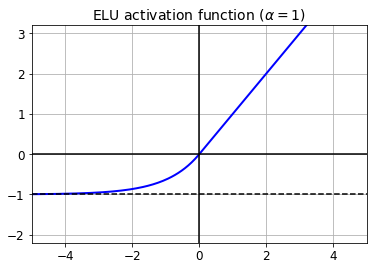

In [ ]:
plt.plot(z, elu(z), "b-", linewidth = 2)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [-1, -1], "k--")
plt.plot([0, 0], [-2.2, 5], 'k-')
plt.grid('True')
plt.title(r"ELU activation function ($\alpha = 1$)", fontsize = 14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = keras.models.Sequential([
              keras.layers.Flatten(input_shape = [28, 28]),
              keras.layers.Dense(300, activation = 'elu', kernel_initializer='he_normal'),
              keras.layers.Dense(100, activation = 'elu', kernel_initializer='he_normal'),
              keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(learning_rate=1e-3),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs = 10, 
                    validation_data = (X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.1200 - accuracy: 0.6462 - val_loss: 0.7926 - val_accuracy: 0.7376
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7228 - accuracy: 0.7570 - val_loss: 0.6567 - val_accuracy: 0.7822
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6316 - accuracy: 0.7878 - val_loss: 0.5992 - val_accuracy: 0.8022
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5824 - accuracy: 0.8044 - val_loss: 0.5553 - val_accuracy: 0.8216
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5508 - accuracy: 0.8149 - val_loss: 0.5298 - val_accuracy: 0.8268
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5281 - accuracy: 0.8201 - val_loss: 0.5104 - val_accuracy: 0.8294
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5108 - accuracy: 0.8253 - val_loss: 0.4949 - val_accuracy:

In [ ]:
history.history['accuracy'][-1], history.history['val_accuracy'][-1]

(0.8351454734802246, 0.8428000211715698)

**SELU:**

Scaled ELU (SELU) is a scaled variant of the ELU activation
function. The authors showed that if you build a neural network composed exclusively
of a stack of dense layers, and if all hidden layers use the SELU activation function,
then the network will self-normalize: the output of each layer will tend to
preserve a mean of 0 and standard deviation of 1 during training, which solves the
vanishing/exploding gradients problem. As a result, the SELU activation function
often significantly outperforms other activation functions for such neural nets (especially
deep ones). There are, however, a few conditions for self-normalization to happen:
* The input features must be standardized (mean 0 and standard deviation 1).
* Every hidden layer’s weights must be initialized with LeCun normal initialization.
In Keras, this means setting kernel_initializer="lecun_normal".
* Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ1 or ℓ2 regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [ ]:
from scipy.special import erfc

#alpha and scale to self normalize with mean 0 and standard deviation 1

alpha_0_1 = -np.sqrt(2/np.pi)/(erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [ ]:
def selu(z, scale = scale_0_1, alpha = alpha_0_1):
  return scale * elu(z, alpha)

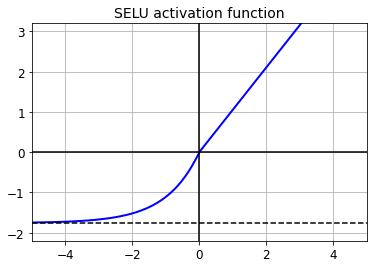

In [ ]:
plt.plot(z, selu(z), "b-", linewidth = 2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize = 14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [ ]:
np.random.seed(42)
Z = np.random.normal(size = (500, 100)) #Standardized inputs
for layer in range(1000):
  W = np.random.normal(size = (100, 100), scale = np.sqrt(1/100)) #LeCun initialization
  Z = selu(np.dot(Z, W))
  means = np.mean(Z, axis = 0).mean()
  stds = np.std(Z, axis = 0).mean()
  if layer % 100 == 0:
    print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [ ]:
#Using SELU is easy

keras.layers.Dense(10, activation='selu', kernel_initializer='lecun_normal')

Let's create a neural net for Fashion MNIST with 100 hidden layers using the SELU activation function:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'))
for layer in range(99):
  model.add(keras.layers.Dense(100, activation = 'selu', kernel_initializer='lecun_normal'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(learning_rate=1e-3),
              metrics = ['accuracy'])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [ ]:
pixel_means = X_train.mean(axis = 0, keepdims = True)
pixel_stds = X_train.std(axis = 0, keepdims=True)
X_train_scaled = (X_train - pixel_means)/pixel_stds
X_valid_scaled = (X_valid - pixel_means)/pixel_stds
X_test_scaled = (X_test - pixel_means)/pixel_stds

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs = 5, 
                    validation_data = (X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 26s 15ms/step - loss: 1.1442 - accuracy: 0.5659 - val_loss: 0.7490 - val_accuracy: 0.7396
Epoch 2/5
1719/1719 [==============================] - 25s 14ms/step - loss: 0.7052 - accuracy: 0.7490 - val_loss: 0.6181 - val_accuracy: 0.7786
Epoch 3/5
1719/1719 [==============================] - 25s 14ms/step - loss: 0.6105 - accuracy: 0.7781 - val_loss: 0.5945 - val_accuracy: 0.7906
Epoch 4/5
1719/1719 [==============================] - 25s 15ms/step - loss: 0.5915 - accuracy: 0.7897 - val_loss: 0.6080 - val_accuracy: 0.7866
Epoch 5/5
1719/1719 [==============================] - 25s 14ms/step - loss: 0.5307 - accuracy: 0.8133 - val_loss: 0.4877 - val_accuracy: 0.8248


Now look at what happens if we try to use the ReLU activation function instead:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'))
for layer in range(99):
  model.add(keras.layers.Dense(100, activation = 'relu', kernel_initializer='he_normal'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = keras.optimizers.SGD(learning_rate=1e-3),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs = 5,
                    validation_data = (X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 22s 13ms/step - loss: 1.7959 - accuracy: 0.2655 - val_loss: 1.7181 - val_accuracy: 0.3566
Epoch 2/5
1719/1719 [==============================] - 22s 13ms/step - loss: 1.1503 - accuracy: 0.5168 - val_loss: 0.9672 - val_accuracy: 0.5622
Epoch 3/5
1719/1719 [==============================] - 22s 13ms/step - loss: 1.0513 - accuracy: 0.5748 - val_loss: 0.9552 - val_accuracy: 0.6096
Epoch 4/5
1719/1719 [==============================] - 23s 13ms/step - loss: 0.8668 - accuracy: 0.6635 - val_loss: 0.7753 - val_accuracy: 0.7068
Epoch 5/5
1719/1719 [==============================] - 23s 13ms/step - loss: 0.7422 - accuracy: 0.7208 - val_loss: 0.6852 - val_accuracy: 0.7444


Not great, we suffered from the vanishing/exploding gradients problem

**Batch Normalization**

Although using He initialization along with ELU (or any variant of ReLU) can significantly
reduce the danger of the vanishing/exploding gradients problems at the begin
ning
of training, it doesn’t guarantee that they won’t come back during training.


The technique consists of
adding an operation in the model just before or after the activation function of each
hidden layer. This operation simply zero-centers and normalizes each input, then
scales and shifts the result using two new parameter vectors per layer: one for scaling,
the other for shifting. In other words, the operation lets the model learn the optimal
scale and mean of each of the layer’s inputs. In many cases, if you add a BN layer as
the very first layer of your neural network, you do not need to standardize your train
ing
set (e.g., using a StandardScaler); the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).
In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and standard deviation of the input over the current mini-batch (hence the name “Batch Normalization”).


Implementing Batch Normalization is simple and
intuitive. Just add a BatchNormalization layer before or after each hidden layer’s
activation function, and optionally add a BN layer as well as the first layer in your
model. For example, this model applies BN after every hidden layer and as the first
layer in the model (after flattening the input images):

In [ ]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape = [28, 28]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300, activation='elu', kernel_initializer = 'he_normal'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_214 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_215 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_216 (Dense)            (None, 10)               

As you can see, each BN layer adds four parameters per input: γ, β, μ, and σ (for
example, the first BN layer adds 3,136 parameters, which is 4 × 784). The last two
parameters, μ and σ, are the moving averages; they are not affected by backpropagation,
so Keras calls them “non-trainable” (if you count the total number of BN
parameters, 3,136 + 1,200 + 400, and divide by 2, you get 2,368, which is the total
number of non-trainable parameters in this model).

In [ ]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [ ]:
bn1.updates

[<tf.Operation 'cond/Identity' type=Identity>,
 <tf.Operation 'cond_1/Identity' type=Identity>]

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(lr = 1e-3),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs = 10,
                    validation_data = (X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.9021 - accuracy: 0.6946 - val_loss: 0.6000 - val_accuracy: 0.8004
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6103 - accuracy: 0.7904 - val_loss: 0.5162 - val_accuracy: 0.8240
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5540 - accuracy: 0.8078 - val_loss: 0.4786 - val_accuracy: 0.8354
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5171 - accuracy: 0.8212 - val_loss: 0.4543 - val_accuracy: 0.8454
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4936 - accuracy: 0.8275 - val_loss: 0.4383 - val_accuracy: 0.8492
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4771 - accuracy: 0.8339 - val_loss: 0.4259 - val_accuracy: 0.8520
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4641 - accuracy: 0.8384 - val_loss: 0.4140 - val_accuracy:

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a BatchNormalization layer does not need to have bias terms, since the BatchNormalization layer some as well, it would be a waste of parameters, so you can set use_bias=False when creating those layers:

In [ ]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape = [28,28]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300, use_bias = False),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dense(100, use_bias = False),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dense(10, activation = 'softmax')
])

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(learning_rate = 1e-3),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs = 10,
                    validation_data = (X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.0317 - accuracy: 0.6757 - val_loss: 0.6765 - val_accuracy: 0.7812
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6790 - accuracy: 0.7793 - val_loss: 0.5560 - val_accuracy: 0.8180
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5960 - accuracy: 0.8037 - val_loss: 0.4999 - val_accuracy: 0.8362
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5447 - accuracy: 0.8192 - val_loss: 0.4657 - val_accuracy: 0.8448
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5109 - accuracy: 0.8279 - val_loss: 0.4424 - val_accuracy: 0.8532
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4898 - accuracy: 0.8337 - val_loss: 0.4252 - val_accuracy: 0.8546
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4712 - accuracy: 0.8397 - val_loss: 0.4119 - val_accuracy:

# Gradient Clipping

Another popular technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold. This is
called Gradient Clipping. This technique is most often used in recurrent neural networks, as Batch Normalization is tricky to use in RNNs.
For other types of networks, BN is usually sufficient.

In [ ]:
optimizer = keras.optimizers.SGD(clipvalue = 1.0)

In [ ]:
optimizer = keras.optimizers.SGD(clipnorm = 1.0)

# Reusing Pretrained Layers

**Reusing a Keras model**

Let's split the fashion MNIST training set in two:

* X_train_A: all images of all items except for sandals and shirts (classes 5 and 6).
* X_train_B: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image).

In [ ]:
def split_dataset(X, y):
  y_5_or_6 = (y == 5) | (y == 6) #Sandals or shirts
  y_A = y[~y_5_or_6]
  y_A[y_A > 6] -=2 #class indices 7, 8, 9 should be moved to 5, 6, 7
  y_B = (y[y_5_or_6] == 6).astype(np.float32) #binary classification task: is it a shirt (class 6)?
  return ((X[~y_5_or_6], y_A),
          (X[y_5_or_6], y_B))
  
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [ ]:
# Model A contains all the label except 5 and 6
X_train_A.shape

(43986, 28, 28)

In [ ]:
# Model B contains only label 5 or 6
X_train_B.shape

(200, 28, 28)

In [ ]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [ ]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape = [28,28]))
for n_hidden in (300, 100, 50, 50, 50):
  model_A.add(keras.layers.Dense(n_hidden, activation = 'selu', kernel_initializer='lecun_normal'))
model_A.add(keras.layers.Dense(8, activation = 'softmax'))

In [ ]:
model_A.compile(loss = "sparse_categorical_crossentropy",
                optimizer = keras.optimizers.SGD(learning_rate=1e-3),
                metrics = ['accuracy'])

In [ ]:
history = model_A.fit(X_train_A, y_train_A, epochs = 20,
                      validation_data = (X_valid_A, y_valid_A))

In [ ]:
model_A.save("my_model_A.h5")

In [ ]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape = [28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
  model_B.add(keras.layers.Dense(n_hidden, activation='selu', kernel_initializer='lecun_normal'))

model_B.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model_B.compile(loss = "binary_crossentropy", 
                optimizer = keras.optimizers.SGD(learning_rate=1e-3),
                metrics = ['accuracy'])

In [ ]:
history = model_B.fit(X_train_B, y_train_B, epochs = 20,
                      validation_data = (X_valid_B, y_valid_B))

In [ ]:
model_B.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_226 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_227 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_228 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_229 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_230 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_231 (Dense)            (None, 1)                

In [ ]:
model_A = keras.models.load_model("my_model_A.h5")

In [ ]:
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [ ]:
for layer in model_B_on_A.layers[:-1]:
  layer.trainable = False

model_B_on_A.compile(loss = 'binary_crossentropy',
                     optimizer = keras.optimizers.SGD(lr = 1e-4),
                     metrics = ['accuracy'])

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs = 20,
                           validation_data = (X_valid_B, y_valid_B))

In [ ]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1060 - accuracy: 0.9835


[0.10604177415370941, 0.9835000038146973]

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.5985 - accuracy: 0.6525


[0.5984948873519897, 0.6524999737739563]

# Faster Optimizers

Training a very large deep neural network can be painfully slow. So far we have seen
four ways to speed up training (and reach a better solution): applying a good initialization strategy for the connection weights, using a good activation function, using
Batch Normalization, and reusing parts of a pretrained network (possibly built on an
auxiliary task or using unsupervised learning). Another huge speed boost comes from
using a faster optimizer than the regular Gradient Descent optimizer.

**Momentum Optimization**

Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal
velocity (if there is some friction or air resistance). This is the very simple idea behind *momentum optimization*.
In contrast, regular Gradient Descent will simply take small, regular steps down the slope, so the algorithm will take much more time to reach the bottom. 


Momentum optimization cares a great deal about what previous gradients were: at
each iteration, it subtracts the local gradient from the *momentum vector* **m** (multiplied
by the learning rate $\eta$.), and it updates the weights by adding this momentum vector. In other words, the gradient is used for acceleration, not
for speed. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter $\beta$, called the
momentum, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

**Nesterov Accelerated Gradient**

The Nesterov Accelerated
Gradient (NAG) method, also known as Nesterov momentum optimization, measures
the gradient of the cost function not at the local position $\theta$. but slightly ahead in the direction of the momentum, at $\theta + \beta$**m**

In [ ]:
optimizer = keras.optimizers.SGD(lr = 0.001, momentum=0.9, nesterov=True)

**AdaGrad**

Consider the elongated bowl problem again: Gradient Descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley. It would be nice if the algorithm
could correct its direction earlier to point a bit more toward the global optimum. The AdaGrad algorithm15 achieves this correction by scaling down the gradient vector along the steepest dimensions.

AdaGrad frequently performs well for simple quadratic problems, but it often stops too early when training neural networks. The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum.

In [ ]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

**RMSProp**

As we've seen, AdaGrad runs the risk of slowing down a bit too fast and never converging to the global optimum. The *RMSProp* algorithm fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training). It does so by using exponential decay. The decay rate $\beta$ is typically set to 0.9.

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho = 0.9)

**Adam Optimization:**

Adam, which stands for *adaptive moment estimation*, combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients. 

Since Adam is an adaptive learning rate algorithm (like AdaGrad and RMSProp), it requires less tuning of the learning rate hyperparameter $\eta$. We can often use the default value $\eta$ = 0.001, making Adam even easier to use than Gradient Descent.

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

**Adamax Optimization**

In [ ]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

**Nadam Optimization:**

Nadam optimization is Adam optimization plus the Nesterov trick, so it will
often converge slightly faster than Adam.


In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Learning Rate Scheduling

Finding a good learning rate is very important. If you set it much too high, training may diverge. If you set it too
low, training will eventually converge to the optimum, but it will take a very long time. If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never really settling down. If you have a
limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution.

A beneficial method is to start with a low learning rate, increase it, then drop it again. These strategies are called *learning schedules*.

**Power Scheduling**

lr = lr0/(1 + steps/s)**c

* Keras uses c = 1, and s = 1/decay

In [ ]:
optimizer = keras.optimizers.SGD(lr = 0.01, decay = 1e-4)

In [ ]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape = [28, 28]),
        keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'),
        keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
        keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = optimizer,
              metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs = 25,
                    validation_data = (X_valid_scaled, y_valid))

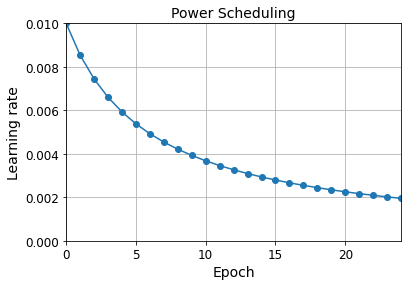

In [ ]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_epochs = 25
n_steps_per_epoch = len(X_train)//batch_size #1718
epochs = np.arange(n_epochs)
lrs = learning_rate/(1+decay*epochs*n_steps_per_epoch)

plt.plot(epochs, lrs, "o-")
plt.axis([0, n_epochs-1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Power Scheduling", fontsize = 14)
plt.grid(True)
plt.show()

**Exponential Scheduling**

lr = lr0 * 0.1 ** (epoch/s)

In [ ]:
def exponential_decay_fn(epoch):
  return 0.01 * 0.1**(epoch/20)

In [ ]:
def exponential_decay(lr0, s):
  def exponential_decay_fn(epoch):
    return lr0 * 0.1**(epoch/s)
  return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0 = 0.01, s = 20)

In [ ]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape = [28,28]),
        keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'),
        keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
        keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer='nadam', metrics = ['accuracy'])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs = 25,
                    validation_data = (X_valid_scaled, y_valid),
                    callbacks = [lr_scheduler])

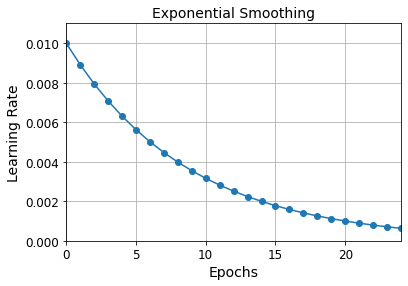

In [ ]:
plt.plot(history.epoch, history.history['lr'], 'o-')
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Exponential Smoothing", fontsize = 14)
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [ ]:
def exponential_decay_fn(epoch, lr):
  return lr * 0.1**(1/20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [ ]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
  def __init__(self, s = 40000):
    super().__init__()
    self.s = s

  def on_batch_begin(self, batch, logs = None):
    #Note: the "batch" argument is reset at each epoch
    lr = K.get_value(self.model.optimizer.lr)
    K.set_value(self.model.optimizer.lr, lr*0.1**(1/s))

  def on_epoch_end(self, epoch, logs = None):
    logs = logs or {}
    logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
        keras.layers.Flatten(input_shape = [28, 28]),
        keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'),
        keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
        keras.layers.Dense(10, activation='softmax')
])

lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr = lr0)
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = optimizer, metrics = ['accuracy'])

n_epochs = 25
s = 20*len(X_train)//32 #Number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs = n_epochs,
                    validation_data = (X_valid_scaled, y_valid),
                    callbacks = [exp_decay])

In [ ]:
n_steps = n_epochs * len(X_train)//32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps/s)

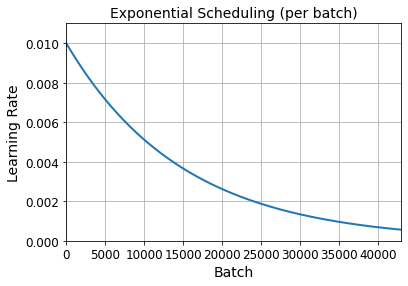

In [ ]:
plt.plot(steps, lrs, "-", linewidth = 2)
plt.axis([0, n_steps - 1, 0, lr0*1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize = 14)
plt.grid(True)
plt.show()

**Piecewise Constant Scheduling**


In [ ]:
def piecewise_constant_fn(epoch):
  if epoch < 5:
    return 0.01
  elif epoch < 15:
    return 0.005
  else: 
    return 0.001

In [ ]:
def piecewise_constant(boundaries, values):
  boundaries = np.array([0] + boundaries)
  values = np.array(values)
  def piecewise_constant_fn(epoch):
    return values[np.argmax(boundaries > epoch) - 1]
  return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
        keras.layers.Flatten(input_shape = [28, 28]),
        keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'),
        keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
        keras.layers.Dense(10, activation='softmax')                        
])

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = 'nadam',
              metrics = ['accuracy'])
n_epochs = 25

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs = n_epochs,
                    validation_data = (X_valid_scaled, y_valid),
                    callbacks = [lr_scheduler])

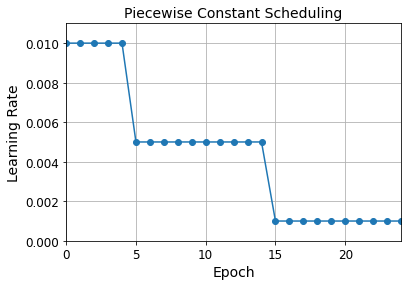

In [ ]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize = 14)
plt.grid(True)
plt.show()

In [ ]:
#Try this:

learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries = [5 * n_steps_per_epoch, 15*n_steps_per_epoch],
    values = [0.01, 0.005, 0.001]
)

**Performance Scheduling**

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience = 5)

model = keras.models.Sequential([
        keras.layers.Flatten(input_shape = [28, 28]),
        keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'),
        keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
        keras.layers.Dense(10, activation='softmax')
        ])

In [ ]:
optimizer = keras.optimizers.SGD(lr = 0.02, momentum = 0.9)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = optimizer, 
              metrics = ['accuracy'])

In [ ]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs = n_epochs,
                    validation_data = (X_valid_scaled, y_valid),
                    callbacks = [lr_scheduler])

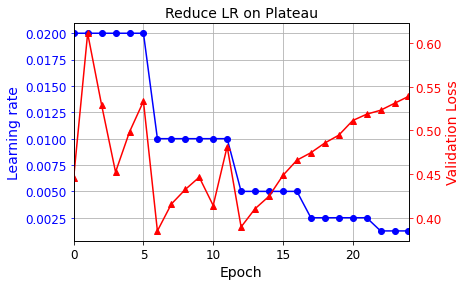

In [ ]:
plt.plot(history.epoch, history.history['lr'], 'bo-')
plt.xlabel("Epoch")
plt.ylabel("Learning rate", color = 'b')
plt.tick_params("y", colors = 'b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history['val_loss'], "r^-")
ax2.set_ylabel("Validation Loss", color = 'r')
ax2.tick_params('y', colors = 'r')
plt.title("Reduce LR on Plateau", fontsize = 14)
plt.show()

**tf.keras. schedulers**

In [ ]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28,28]),
        keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'),
        keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
        keras.layers.Dense(10, activation = 'softmax')
])

In [ ]:
s = 20*len(X_train)//32 #Number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer=optimizer, metrics = ['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs = n_epochs,
                    validation_data = (X_valid_scaled, y_valid))

**1Cycle scheduling**

In [ ]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):

  def __init__(self, factor):
    self.factor = factor
    self.rates = []
    self.losses = []
  def on_batch_end(self, batch, logs):
    self.rates.append(K.get_value(self.model.optimizer.lr))
    self.losses.append(logs['loss'])
    K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs = 1, batch_size = 32, min_rate = 10**-5, max_rate=10):
  init_weights = model.get_weights()
  iterations = len(X)//batch_size*epochs
  factor = np.exp(np.log(max_rate/min_rate)/iterations)
  init_lr = K.get_value(model.optimizer.lr)
  K.set_value(model.optimizer.lr, min_rate)
  exp_lr = ExponentialLearningRate(factor)
  history = model.fit(X, y, epochs = epochs, batch_size = batch_size,
                      callbacks = [exp_lr])
  K.set_value(model.optimizer.lr, init_lr)
  model.set_weights(init_weights)
  return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
  plt.plot(rates, losses)
  plt.gca().set_xscale('log')
  plt.hlines(min(losses), min(rates), max(rates))
  plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses))/2])
  plt.xlabel("Learning Rate")
  plt.ylabel("Loss")

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 2s 6ms/step - loss: nan - accuracy: 0.3862


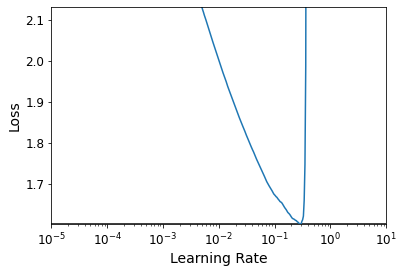

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [ ]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

# **Avoiding Overfitting Through Regularization**

With thousands of parameters, you can fit the whole zoo. Deep neural networks typically have tens of thousands of parameters, sometimes even millions. This gives them an incredible amount of freedom and means they can fit a huge variety of complex datasets. But this great flexibility also makes the network prone to overfitting the
training set. We need regularization.

**l<sub>1</sub> and l<sub>2</sub> regularization**

In [ ]:
layer = keras.layers.Dense(100, activation = 'elu',
                           kernel_initializer = 'he_normal',  
                           kernel_regularizer = keras.regularizers.l2(0.01)
                           )
# or l1(0.1) for l1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both l1 and l2  regularization, with factors 0.1 and 0.01 respectively

In [ ]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape = [28, 28]),
        keras.layers.Dense(300, activation = 'elu', kernel_initializer = "he_normal", kernel_regularizer = keras.regularizers.l2(0.01)),
        keras.layers.Dense(100, activation = 'elu', kernel_initializer = 'he_normal', kernel_regularizer = keras.regularizers.l2(0.01)),
        keras.layers.Dense(10, activation = 'softmax', kernel_regularizer = keras.regularizers.l2(0.01))
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 7ms/step - loss: 1.6698 - accuracy: 0.8116 - val_loss: 0.7189 - val_accuracy: 0.8324
Epoch 2/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7182 - accuracy: 0.8276 - val_loss: 0.6814 - val_accuracy: 0.8376


In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation = 'elu',
                           kernel_initializer = 'he_normal',
                           kernel_regularizer = keras.regularizers.l2(0.01))

model = keras.models.Sequential([
        keras.layers.Flatten(input_shape = [28, 28]),
        keras.layers.Dense(300),
        keras.layers.Dense(100),
        keras.layers.Dense(10, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'nadam', metrics = ['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs = 10,
                    validation_data = (X_valid_scaled, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5891 - accuracy: 0.8092 - val_loss: 0.4921 - val_accuracy: 0.8424
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4754 - accuracy: 0.8378 - val_loss: 0.4459 - val_accuracy: 0.8502
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4540 - accuracy: 0.8435 - val_loss: 0.4595 - val_accuracy: 0.8416
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4456 - accuracy: 0.8448 - val_loss: 0.4503 - val_accuracy: 0.8470
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4348 - accuracy: 0.8486 - val_loss: 0.4405 - val_accuracy: 0.8502
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4303 - accuracy: 0.8500 - val_loss: 0.4455 - val_accuracy: 0.8490
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4260 - accuracy: 0.8520 - val_loss: 0.4450 - val_accuracy:

**Dropout**

It is a fairly simple algorithm: at every training step, every neuron (including the
input neurons, but always excluding the output neurons) has a probability p of being
temporarily “dropped out,” meaning it will be entirely ignored during this training
step, but it may be active during the next step. The hyperparameter
p is called the dropout rate, and it is typically set between 10% and 50%: closer to 20–
30% in recurrent neural nets, and closer to 40–50% in convolutional
neural networks. After training, neurons don’t get dropped any
more.

In [ ]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape = [28, 28]),
        keras.layers.Dropout(rate = 0.2),
        keras.layers.Dense(300, activation = 'elu', kernel_initializer='he_normal'),
        keras.layers.Dropout(rate = 0.2),
        keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
        keras.layers.Dropout(rate = 0.2),
        keras.layers.Dense(10, activation='softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = 'nadam', metrics = ['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs = 5,
                    validation_data = (X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5775 - accuracy: 0.8027 - val_loss: 0.3777 - val_accuracy: 0.8624
Epoch 2/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4193 - accuracy: 0.8470 - val_loss: 0.3396 - val_accuracy: 0.8732
Epoch 3/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3871 - accuracy: 0.8561 - val_loss: 0.3429 - val_accuracy: 0.8674
Epoch 4/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3686 - accuracy: 0.8629 - val_loss: 0.3143 - val_accuracy: 0.8830
Epoch 5/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3572 - accuracy: 0.8669 - val_loss: 0.3005 - val_accuracy: 0.8900


**Alpha Dropout**


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape = [28, 28]),
        keras.layers.AlphaDropout(rate = 0.2),
        keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'),
        keras.layers.AlphaDropout(rate = 0.2),
        keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
        keras.layers.AlphaDropout(rate = 0.2),
        keras.layers.Dense(10, activation='softmax')
])

In [ ]:
optimizer = keras.optimizers.SGD(lr = 0.01, momentum=0.9, nesterov=True)
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer=optimizer, metrics = ['accuracy'])

In [ ]:
model.fit(X_train_scaled, y_train, epochs = 20, 
          validation_data = (X_valid_scaled, y_valid))

In [ ]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4625 - accuracy: 0.8631


[0.4625047743320465, 0.863099992275238]

**MC Dropout**



In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [ ]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.93]],
      dtype=float32)

In [ ]:
np.round(y_probas[:, :1], 2)

In [ ]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.29, 0.  , 0.6 ]],
      dtype=float32)

In [ ]:
y_std = y_probas.std(axis = 0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.19, 0.  , 0.27, 0.  , 0.31]],
      dtype=float32)

In [ ]:
y_pred = np.argmax(y_proba, axis = 1)

In [ ]:
accuracy = np.sum(y_pred == y_test)/len(y_test)
accuracy

0.8656

In [ ]:
class MCDroput(keras.layers.Dropout):
  def call(self, inputs):
    return super().call(inputs, training = True)

class MCAlphaDroput(keras.layers.AlphaDropout):
  def call(self, inputs):
    return super().call(inputs, training = True)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
mc_model = keras.models.Sequential([
           MCAlphaDroput(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer for layer in model.layers
])

In [ ]:
mc_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_droput_3 (MCAlphaDr (None, 784)               0         
_________________________________________________________________
dense_278 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_droput_4 (MCAlphaDr (None, 300)               0         
_________________________________________________________________
dense_279 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_droput_5 (MCAlphaDr (None, 100)               0         
_________________________________________________________________
dense_280 (Dense)            (None, 10)              

In [ ]:
optimizer = keras.optimizers.SGD(lr = 0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss = "sparse_categorical_crossentropy", 
                 optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
mc_model.set_weights(model.get_weights())

In [ ]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis = 0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.35, 0.  , 0.57]],
      dtype=float32)

**Max Norm**

In [ ]:
layer = keras.layers.Dense(100, activation = 'selu', kernel_initializer='lecun_normal', kernel_constraint=keras.constraints.max_norm(1.))

In [ ]:
MaxNormDense = partial(keras.layers.Dense, activation = 'selu', kernel_initializer = 'lecun_normal', kernel_constraint = keras.constraints.max_norm(1.))

model = keras.models.Sequential([
        keras.layers.Flatten(input_shape = [28, 28]),
        MaxNormDense(300),
        MaxNormDense(100),
        keras.layers.Dense(10, activation='softmax')
])

model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = 'nadam', metrics = ['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs = 20, 
                    validation_data = (X_valid_scaled, y_valid))